# 다중 클래스 분류 모델(컨볼루션 신경망 모델)

# 0. 사용할 패키지 불러오기

In [1]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

### 데이터 셋 준비 
- 로이터에서 제공하는 뉴스와이어 데이터셋을 이용
- 이 데이터셋은 총 11,228개의 샘플로 구성
- 라벨은 46개 주제로 지정되어 0에서 45의 값을 가지고 있음
- 데이터셋은 이미 정수로 인코딩되어 있으며, 정수값은 단어의 빈도수를 나타냄 
- 모든 단어를 고려할 수 없으므로 빈도수가 높은 단어를 위주로 데이터셋을 생성
- 15,000번째로 많이 사용하는 단어까지만 데이터셋으로 만들고 싶다면, num_words 인자에 15000이라고 지정하면 됨

In [2]:
max_features = 15000  # 15,000 번째로 많이 사용하는 단어까지  
text_max_words = 120  # 최대 워드 갯수 

### 1. 데이터셋 생성하기
#### 훈련셋과 시험셋 불러오기

In [3]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_features)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(8982,)
(8982,)
(2246,)
(2246,)


#### 훈련셋과 검증셋 분리
- 훈련셋 8,982개와 시험셋 2,246개로 구성된 총 11,228개 샘플이 로딩
- 훈련셋과 시험셋의 비율은 load_data() 함수의 test_split 인자로 조절 가능 함
- 각 샘플은 뉴스 한 건을 의미하며, 단어의 인덱스로 구성되어 있습니다. 
- num_words=15000으로 지정했기 때문에 빈도수가 15,000을 넘는 단어는 로딩되지 않음
- 훈련셋 8,982개 중 다시 7,000개을 훈련셋으로 나머지를 검증셋으로 분리

In [4]:
x_val = x_train[7000:]
y_val = y_train[7000:]
x_train = x_train[:7000]
y_train = y_train[:7000]

#### 데이터셋 전처리 : 문장 길이 맞추기
- 각 샘플의 길이가 달라서 모델의 입력으로 사용하기 위해 케라스에서 제공되는 전처리 함수인 sequence의 pad_sequences() 함수를 사용
- 이 함수는 두 가지 역할을 수행함
    - 문장의 길이를 maxlen 인자로 맞춰줌 
    - 예를 들어 120으로 지정했다면 120보다 짧은 문장은 0으로 채워서 120단어로 맞춰주고 120보다 긴 문장은 120단어까지만 잘라냄
    - (num_samples, num_timesteps)으로 2차원의 numpy 배열로 만들어줍니다. 
    - maxlen을 120으로 지정하였다면, num_timesteps도 120이 됩니다.

In [5]:
x_train = sequence.pad_sequences(x_train, maxlen=text_max_words)
x_val = sequence.pad_sequences(x_val, maxlen=text_max_words)
x_test = sequence.pad_sequences(x_test, maxlen=text_max_words)

#### one-hot 인코딩

In [6]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

### 2. 모델 구성하기(다층퍼셉트론 신경망 모델)
- 임베딩 레이어는 0에서 45의 정수값으로 지정된 단어를 128벡터로 인코딩합니다. 
- 문장의 길이가 120이므로 임베딩 레이어는 128 속성을 가진 벡터를 120개 반환합니다. 
- 이를 Flatten 레이어를 통해 1차원 벡터로 만든 뒤 전결합층으로 전달합니다. 
- 46개 주제를 분류해야 하므로 출력층의 활성화 함수로 ‘softmax’를 사용하였습니다.)

In [7]:
model = Sequential()
model.add(Embedding(max_features, 128, input_length=text_max_words))
model.add(Dropout(0.2))
model.add(Conv1D(256,
                 3,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(46, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 128)          1920000   
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 118, 256)          98560     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5

### 3. 모델 학습과정 설정하기

In [8]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### 4. 모델 학습시키기

In [9]:
hist = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/10
110/110 [==============================] - 3s 25ms/step - loss: 2.2757 - accuracy: 0.4470 - val_loss: 1.7393 - val_accuracy: 0.5434
Epoch 2/10
110/110 [==============================] - 3s 24ms/step - loss: 1.5813 - accuracy: 0.6227 - val_loss: 1.3407 - val_accuracy: 0.6902
Epoch 3/10
110/110 [==============================] - 3s 23ms/step - loss: 1.2340 - accuracy: 0.7069 - val_loss: 1.1986 - val_accuracy: 0.7134
Epoch 4/10
110/110 [==============================] - 3s 23ms/step - loss: 0.9920 - accuracy: 0.7657 - val_loss: 1.0962 - val_accuracy: 0.7432
Epoch 5/10
110/110 [==============================] - 3s 23ms/step - loss: 0.7713 - accuracy: 0.8109 - val_loss: 1.0582 - val_accuracy: 0.7563
Epoch 6/10
110/110 [==============================] - 3s 23ms/step - loss: 0.5927 - accuracy: 0.8510 - val_loss: 1.0729 - val_accuracy: 0.7568
Epoch 7/10
110/110 [==============================] - 3s 24ms/step - loss: 0.4447 - accuracy: 0.8876 - val_loss: 1.1138 - val_accuracy: 0.7619

### 5. 학습과정 살펴보기

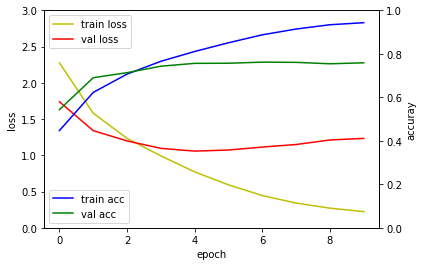

In [10]:
%matplotlib inline

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 3.0])

acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylim([0.0, 1.0])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 6. 모델 평가하기

In [11]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

36/36 [==============================] - 0s 4ms/step - loss: 1.2586 - accuracy: 0.7511
## evaluation loss and_metrics ##
[1.2585772275924683, 0.7511131167411804]
